# MCMC for Coin Toss 

In [3]:
# import libraries
try:
  import distrax
except:
  %pip install -qq distrax
  import distrax
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import ipywidgets as widgets
import jax
import jax.numpy as jnp
import logging
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

# Model description
<h2>Prior</h2>

$\theta \sim Beta(\alpha,\beta)$

<h2>Likelihood</h2>

$x \sim Bernoulli(\theta)$


In [4]:
def get_data(file_name):
    with open(file_name,'rb') as f:
        all_data = pickle.load(f)
    samples = all_data['samples']
    alpha_prior = all_data['prior']['alpha']
    beta_prior = all_data['prior']['beta']
    return samples, alpha_prior, beta_prior

In [5]:
samples, alpha_prior , beta_prior = get_data("../data/coin_toss")
samples = jnp.array(samples)

Lets get the samples now.

In [6]:
samples,alpha_prior,beta_prior

(DeviceArray([1, 1, 0, 1, 1, 1, 1, 1, 0, 1], dtype=int32), 10, 15)

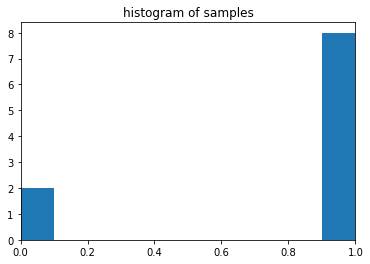

In [7]:
plt.hist(samples)
plt.xlim(0,1)
plt.title("histogram of samples")
plt.show()

In [8]:
prior_beta_dist = tfd.Beta(alpha_prior,beta_prior)

In [9]:

def log_postfn(x):
  prob = jax.nn.sigmoid(x)
  log_prior = prior_beta_dist.log_prob(prob)
  like_bernoulli = tfd.Bernoulli(x)
  log_like = jnp.array([jnp.sum(like_bernoulli.log_prob(samples))])
  return (log_like+log_prior)[0]

log_postfn(1)

DeviceArray(-9.545955, dtype=float32)

RMH here stands for Random walk Metropolis Hastings.
We will use the blackjax implementation of it.

Things we have to do using jax


*   rmh takes the log of posterior pdf and sigma is the walk length parameter. So give them.
*   Then define the initial state of the rmh. This is done by just giving the initial value of whatever we are trying to estimate.




In [10]:
rmh = blackjax.rmh(log_postfn, sigma = jnp.array([2]))
m = jnp.array([20.0])
initial_state = rmh.init(m)
initial_state

RMHState(position=DeviceArray([20.], dtype=float32), log_probability=DeviceArray(-inf, dtype=float32))

I don't have a good idea of how the below fn works but it will give us the samples that we need.

In [11]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

Lets generate samples from posterior distribution now.

In [12]:
rng_key = jax.random.PRNGKey(0)
_, rng_key = jax.random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 10000)

lets now see how it is varying. As we can see from the below figure, the parameter is changing a lot durin the first 300 iterations and then having a stationary distribution. So we eliminate the first 300 samples and then just take a target distribution as the emperical distribution of the samples.

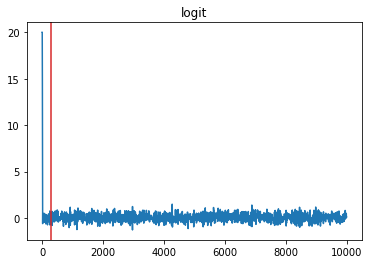

In [13]:
burnin = 300
fig, ax = plt.subplots()
ax.plot(states.position[:,0])
ax.set_title(f"logit")
ax.axvline(x=burnin, c="tab:red")
plt.show()

In [15]:
import pickle
with open("../results/coin_toss/MCMC_BlackJAX","wb") as f:
    pickle.dump(jax.nn.sigmoid(states.position[300:,0]),f)
# plt.hist(jax.nn.sigmoid(states.position[300:,0]),density=True,bins=20)

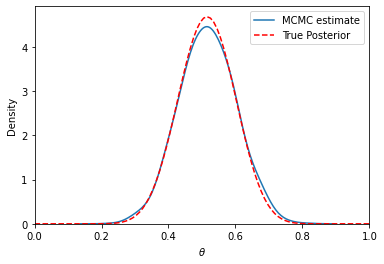

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_true_posterior():
    samples,alpha_prior,beta_prior = get_data("../data/coin_toss")
    x = jnp.linspace(0,1,100)
    one= jnp.sum(samples==1).astype('float32')
    zero= jnp.sum(samples==0).astype('float32')
    true_post_dist = tfd.Beta(alpha_prior+one,beta_prior+zero)
    true_post_pdf = true_post_dist.prob(x)
    plt.plot(x,true_post_pdf,'r--',label="True Posterior")     
    plt.xlabel(r"$\theta$")
    plt.legend()
    plt.xlim(0,1)

with open("../results/coin_toss/MCMC_BlackJAX",'rb') as f:
    states = jnp.array(pickle.load(f))
sns.kdeplot(states,bw_adjust=2,label="MCMC estimate")
plot_true_posterior()
plt.show()